### Saving data
````julia
using JLD2
a = randn(2,2)
x = (1,a)
save_object("tuble.jld2",x)
data = load_object("tuble.jld2")
data[2]
````

In [6]:
using Flux,LinearAlgebra,CairoMakie,Random,ProgressMeter,JLD2


include("DenseNTK.jl") # layers in julia
include("normNTK.jl") # kernel
include("FastNTK.jl")


Fkernel (generic function with 2 methods)

In [12]:
# The model
Random.seed!(123)
Nh = 10_000 # number of nodes in hidden layer
model = Chain(DenseNTK(1=>Nh,relu),DenseNTK(Nh=>1))|>f64
θ = Flux.params(model)

# The data
Nx = 40
xa = -1.0
xb = 1.0
xR = range(xa,stop=xb,length=Nx)
x = hcat(xR...)

K = kernel(model,x,true)
λ = eigen(K).values



Computing kernel: 100%|██████████████████████████████████████████████████| Time: 0:00:19


40-element Vector{Float64}:
  0.0034371862480640377
  0.003881576784185097
  0.00397594244561791
  0.004130162607079593
  0.00423548070185896
  0.0043318559756723544
  0.004404162398050709
  0.004503495674355198
  0.004621621427722737
  0.004807990031465546
  ⋮
  0.04487754481926832
  0.05676834852459079
  0.0792538157435016
  0.11311851093546975
  0.19334953223889834
  0.3789791984842663
  1.386751979363476
 12.69276324604149
 38.23382642337905

In [14]:
FastK = Fkernel(model,x,true)

40×40 Matrix{Float64}:
 1.97326   1.91437   1.8589    1.79938   …  0.356934  0.338696  0.321581
 1.91437   1.87549   1.82249   1.76552      0.37319   0.355323  0.338625
 1.8589    1.82249   1.78597   1.73157      0.390424  0.372961  0.356711
 1.79938   1.76552   1.73157   1.69785      0.408665  0.391628  0.375849
 1.74094   1.70956   1.67814   1.64696      0.427379  0.410861  0.395646
 1.68125   1.65237   1.62347   1.59483   …  0.447114  0.431126  0.416486
 1.62391   1.59743   1.57096   1.54478      0.468674  0.453184  0.439086
 1.56411   1.54004   1.51602   1.49231      0.491187  0.476278  0.462808
 1.50728   1.48553   1.46385   1.4425       0.515871  0.501558  0.488727
 1.45113   1.43164   1.41225   1.39322      0.541276  0.527658  0.515568
 ⋮                                       ⋱                      
 0.489424  0.502213  0.515794  0.530243     1.46719   1.48689   1.50911
 0.464041  0.477494  0.491769  0.506936     1.51889   1.54088   1.56543
 0.439741  0.453768  0.46865   0.48444

In [10]:
round.(K,digits=12) == round.(FastK,digits=12)

# K has ETA = 19.4 s
# FastK has ETA = 0.5 s

true

### Kernel and corresponding eigenvalues
````julia
K = kernel(model,x,true)
λ = eigen(K).values

Kλ = (K,λ)
save_object("Kλ_10k_relu.jld2",Kλ)

In [3]:
# K = kernel(model,x,true)
# λ = eigen(K).values

# Kλ = (K,λ)
# save_object("Kλ_10k_relu.jld2",Kλ)

In [22]:
# The kernel and corresponding eigenvalues
Kλ = load_object("Kλ_10k_relu.jld2")
K = Kλ[1]
λ = Kλ[2]


40-element Vector{Float64}:
  0.0034371862480640377
  0.003881576784185097
  0.00397594244561791
  0.004130162607079593
  0.00423548070185896
  0.0043318559756723544
  0.004404162398050709
  0.004503495674355198
  0.004621621427722737
  0.004807990031465546
  ⋮
  0.04487754481926832
  0.05676834852459079
  0.0792538157435016
  0.11311851093546975
  0.19334953223889834
  0.3789791984842663
  1.386751979363476
 12.69276324604149
 38.23382642337905

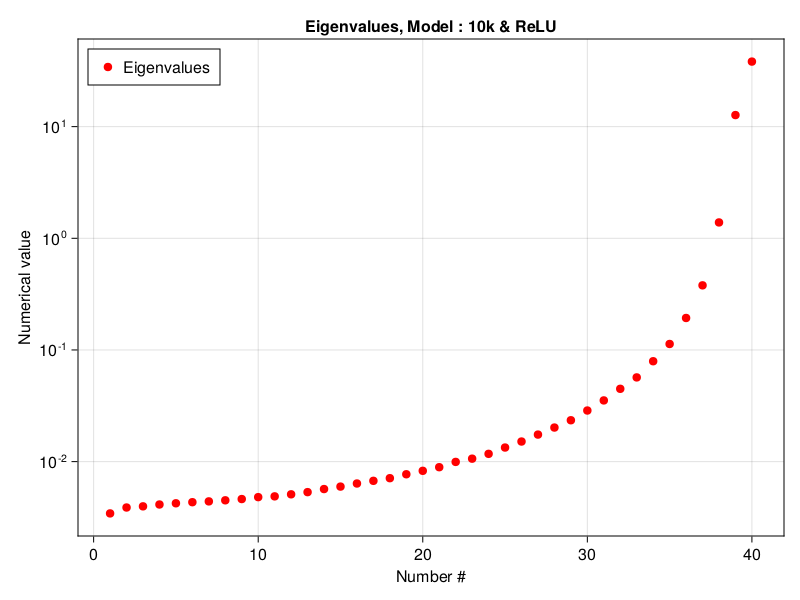

In [23]:
fig = Figure()
grid = fig[1, 1] = GridLayout()
ax1 = Axis(grid[1,1],yscale=log10,xlabel="Number #",ylabel="Numerical value",title="Eigenvalues, Model : 10k & ReLU")
s1 = CairoMakie.scatter!(ax1,λ[:],color=:red,label="Eigenvalues")
axislegend(ax1,position=:lt)

fig

In [24]:
x_train = x
f = x->sin(5*x)+cos(5*x)
y_train = map(f,x_train)
y_hat = model(x_train)
y_train_hat = model(x_train)
Loss(model,x,y) = Flux.mse(y,model(x))
loss = Loss(model,x_train,y_train)
train_data = [(x_train,y_train)]
display(loss)

3.589687700086228

In [25]:
train_data = [(x_train,y_train)]
η = (1/λ[end])
Nepoch = 50000
L = []

progress = Progress(Nepoch, 1)
layer = 3
θ_stop = 6
θ_s = zeros(Nepoch,θ_stop)
for epoch = 1:Nepoch
    Flux.train!(Loss,model,train_data,Descent(η))
    for i = 1:θ_stop
        θ_s[epoch,i] = Flux.params(model)[layer][i]
    end
        
    push!(L,Loss(model,x_train,y_train))

    if epoch % 50 == 0 || epoch == Nepoch
        ProgressMeter.update!(progress, epoch)
    end
end

Progress:   8%|████                                     |  ETA: 0:09:23

DomainError: DomainError with Loss is Inf on data item 1, stopping training:


In [26]:
L

3942-element Vector{Any}:
    23.971047690444685
   219.9641326344948
  1994.7451325423965
 13430.281850449863
 31738.66903186991
 40365.18859742449
 48174.31081766012
 57487.91488789591
 68601.9605397827
 81863.89109101902
     ⋮
     1.2450908053807252e306
     1.4857812578672643e306
     1.772999958468572e306
     2.1157413556568058e306
     2.5247386288169737e306
     3.0127998050412893e306
     3.595208851187125e306
     4.290204301668539e306
    Inf

In [8]:
θ_L_10k_relu_desc30λ = (θ_s,L)
save_object("θ_L_10k_relu_desc30λ.jld2",θ_L_10k_relu_desc30λ)